In [1]:
# 初期設定
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import os, boto3, json, sagemaker, numpy as np
from sagemaker.pytorch import PyTorchModel
from io import BytesIO

def make_dir(path):
    if os.path.isdir(path):
        pass
    else:
        os.mkdir(path)

sagemaker_session = sagemaker.Session()

# AWS設定
# role = 'han_s3_full_access'
role = 'FullAccessHan'
region = boto3.Session().region_name
bucket='sagemaker-han'
bucket='sagemaker-han-batch'
prefix = 'batch-images'
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)
model_prefix = os.path.join(prefix, 'model')
input_prefix = os.path.join(prefix, 'inputs')
output_prefix = os.path.join(prefix, 'outputs')
inference_prefix = os.path.join(prefix, 'inference')

# Local設定
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'data')
model_dir = os.path.join(base_dir, 'model')
input_dir = os.path.join(base_dir, 'inputs')
output_dir = os.path.join(base_dir, 'outputs')
inference_dir = os.path.join(base_dir, 'inference')
source_dir = os.path.join(base_dir, 'src')
for dir_name in [model_dir, input_dir, output_dir, source_dir, inference_dir]:
    make_dir(dir_name)

In [66]:
# Sample 100 datas from CIFAR10 dataset

from src.utils import create_init_sample_data, convert_np_to_png, image_to_bytes

sampled_imgs = create_init_sample_data(data_dir, 100)
convert_np_to_png(inference_dir, sampled_imgs)

# Upload png images to S3
inference_inputs = sagemaker_session.upload_data(
    path=inference_dir, bucket=bucket, key_prefix=inference_prefix
)


Files already downloaded and verified


In [ ]:
import json
from src.utils import create_init_sample_data, convert_np_to_png, image_to_bytes

# sample N images and convert into png
# save in inference_dir
sampled_imgs = create_init_sample_data(data_dir, 100)
convert_np_to_png(inference_dir, sampled_imgs)

with open('sample.jsonl', mode='w') as f:
    _dict = {}
    for inf_file in os.listdir(inference_dir):
        _dict["img_path"] = os.path.join(inference_inputs, inf_file)
        json.dump(_dict, f)
        f.write('\n')



sampled_imgs = create_init_sample_data(data_dir, 100)

f_inference = sagemaker_session.upload_data(path='sample.jsonl', bucket=bucket, key_prefix='batch-images/f_inference')
f_inference = sagemaker_session.upload_data(path='sample2.jsonl', bucket=bucket, key_prefix='batch-images/f_inference')

In [4]:
# Prepare dataset for the model training

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

train_data = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

training_data_loader = DataLoader(train_data, batch_size=len(train_data))
training_data_loaded = next(iter(training_data_loader))
torch.save(training_data_loaded, os.path.join(input_dir, 'training.pt'))

test_data_loader = DataLoader(test_data, batch_size=len(test_data))
test_data_loaded = next(iter(test_data_loader))
torch.save(test_data_loaded, os.path.join(output_dir, 'test.pt'))

inputs = sagemaker_session.upload_data(path=input_dir, bucket=bucket, key_prefix=input_prefix)
outputs = sagemaker_session.upload_data(path=output_dir, bucket=bucket, key_prefix=output_prefix)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
inference_inputs= f's3://{bucket}/batch-images/inference'
inputs= f's3://{bucket}/batch-images/inputs'
outputs= f's3://{bucket}/batch-images/outputs'

In [6]:
# Create Training Container
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="resnet.py",
                    role=role,
                    source_dir = "src",
                    framework_version='1.12.0',
                    py_version='py38',
                    instance_count=1,
                    instance_type='ml.m4.xlarge',
                    hyperparameters={
                        'batch-size':128,
                        'lr': 0.01,
                        'epochs': 1,
                    })

estimator.fit({'training': inputs})

2022-08-22 13:51:32 Starting - Starting the training job...
2022-08-22 13:51:59 Starting - Preparing the instances for trainingProfilerReport-1661176290: InProgress
.........
2022-08-22 13:53:33 Downloading - Downloading input data...
2022-08-22 13:54:13 Training - Downloading the training image......
2022-08-22 13:55:14 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-22 13:55:15,163 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-08-22 13:55:15,165 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-08-22 13:55:15,175 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-22 13:55:15,186 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-08-22 13:55:15,860 sagemaker-training-toolkit INFO     N

In [7]:
cifar10_predictor = estimator.deploy(
    initial_instance_count=1, 
    instance_type='ml.m4.xlarge'
)

--------!

In [8]:
test_input = torch.rand(1,3,32,32)
test_output = cifar10_predictor.predict(test_input)
print(test_input.shape)
print(test_output.shape)

torch.Size([1, 3, 32, 32])
(1, 10)


In [41]:

from sagemaker.pytorch.model import PyTorchModel

# home
model_path = 's3://sagemaker-us-west-2-608095525235/pytorch-training-2022-08-22-14-02-01-637/model.tar.gz'
# fusic
# model_path = 's3://sagemaker-us-west-2-582981179587/pytorch-training-2022-08-22-11-21-23-382/model.tar.gz'

pytorch_model = PyTorchModel(model_data = model_path,
                             entry_point='resnet_batch_transform.py',
                             source_dir = 'src',
                             framework_version='1.12.0',
                             py_version='py38',
                             role = role)

In [90]:
max_concurrent_transforms = 1
max_payload = 1
strategy='SingleRecord'
split_type=None
model_name = 'pytorch-inference-2022-08-23-11-44-10-894'

output_s3_path = 's3://{}/batch-images/outputs/bt_real_{}_{}_{}_{}'.format(bucket, max_concurrent_transforms,max_payload,strategy,split_type)
# f_inference = f's3://{bucket}/batch-images/f_inference'
# transformer.transform(
#     data=f_inference,
#     data_type="S3Prefix",
#     content_type="application/jsonlines",
#     wait=True,
#     split_type=split_type
# )


sagemaker_client = boto3.client('sagemaker')
response = sagemaker_client.create_transform_job(
    TransformJobName='BatchTransformHanNew',
    ModelName=model_name,
    MaxConcurrentTransforms=max_concurrent_transforms,
    MaxPayloadInMB=max_payload,
    BatchStrategy=strategy,
    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': f_inference
            }
        },
        'ContentType': 'application/jsonlines',
        'CompressionType': 'None',
        'SplitType': 'Line'
    },
    TransformOutput={
        'S3OutputPath': output_s3_path,
        'Accept': 'string',
        'AssembleWith': 'None',
    },
    TransformResources={
        'InstanceType': 'ml.m5.xlarge',
        'InstanceCount': 1,
    }
)

# transform_job = sagemaker.transformer.Transformer(
#     model_name = y_xgboost_21,
#     instance_count = 1,
#     instance_type = 'ml.m5.large',
#     strategy = 'SingleRecord',
#     assemble_with = 'Line',
#     output_path = output_data_path,
#     base_transform_job_name='y-test-batch',
#     sagemaker_session=sagemaker.Session(),
#     accept = 'text/csv')

In [42]:
max_concurrent_transforms = 1
max_payload = 1
strategy='SingleRecord'
split_type=None
# strategy='MultiRecord'
# split_type='Line'

output_s3_path = 's3://{}/batch-images/outputs/bt_real_{}_{}_{}_{}'.format(bucket, max_concurrent_transforms,max_payload,strategy,split_type)

transformer = pytorch_model.transformer(instance_count=1,
                              instance_type="ml.m5.xlarge",
                              max_concurrent_transforms=max_concurrent_transforms,
                              max_payload=max_payload,  # 1MB
                              strategy=strategy,
                              output_path=output_s3_path)

f_inference = f's3://{bucket}/batch-images/f_inference'


In [50]:
sagemaker_session.account_id()

'608095525235'

In [51]:
transformer.sagemaker_session.account_id()

'608095525235'

In [43]:

f_inference = f's3://{bucket}/batch-images/f_inference'
transformer.transform(
    data=f_inference,
    data_type="S3Prefix",
    content_type="application/jsonlines",
    wait=True,
    split_type=split_type,
    sagemaker_session=sagemaker_session
)


# transformer = pytorch_model.transformer(instance_count=4,
#                               instance_type="ml.p2.xlarge",
#                               max_concurrent_transforms=2,
#                               max_payload=1,  # 1MB
#                               strategy='MultiRecord',
#                               env={'INFERENCE_PREFERRED_MODE': 'classification'},  # only useful with GPU
#                               output_path=output_s3_path)

# {"in0": [6, 17, 606, 19, 53, 67, 52, 12, 5, 10, 15, 10178, 7, 33, 652, 80, 15, 69, 821, 4], "in1": [16, 21, 13, 45, 14, 9, 80, 59, 164, 4]}
# {"in0": [22, 1016, 32, 13, 25, 11, 5, 64, 573, 45, 5, 80, 15, 67, 21, 7, 9, 107, 4], "in1": [22, 32, 13, 25, 1016, 573, 3252, 4]}
# {"in0": [774, 14, 21, 206], "in1": [21, 366, 125]}

# {"scores":[0.195667684078216,0.395351558923721,0.408980727195739]}
# {"scores":[0.251988261938095,0.258233487606048,0.489778339862823]}
# {"scores":[0.280087798833847,0.368331134319305,0.351581096649169]}



TypeError: transform() got an unexpected keyword argument 'sagemaker_session'

In [24]:
len('s3://sagemaker-han/batch-images/inference/sample31.png')

54

In [128]:
print("Latest transform job:", transformer.latest_transform_job.name)

Latest transform job: pytorch-inference-2022-08-21-08-18-59-697


In [ ]:
transformer.stop_transform_job()

In [113]:
import pprint as pp

job_name = 'pytorch-inference-2022-08-21-03-13-37-242'
sm_cli = sagemaker_session.sagemaker_client
job_info = sm_cli.describe_transform_job(TransformJobName=job_name)
pp.pprint(job_info)

{'CreationTime': datetime.datetime(2022, 8, 21, 12, 13, 37, 860000, tzinfo=tzlocal()),
 'DataProcessing': {'InputFilter': '$',
                    'JoinSource': 'None',
                    'OutputFilter': '$'},
 'FailureReason': 'AlgorithmError: See job logs for more information',
 'ModelName': 'pytorch-inference-2022-08-21-03-13-10-667',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '949',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Sun, 21 Aug 2022 05:10:13 GMT',
                                      'x-amzn-requestid': 'cd218913-c7fe-4e1f-9b31-2b2fa07372d4'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'cd218913-c7fe-4e1f-9b31-2b2fa07372d4',
                      'RetryAttempts': 0},
 'TransformEndTime': datetime.datetime(2022, 8, 21, 12, 18, 21, 796000, tzinfo=tzlocal()),
 'TransformInput': {'CompressionType': 'None',
                    'ContentType'

In [48]:
tmp_model = PyTorchModel(model_data = 's3://sagemaker-us-west-2-582981179587/pytorch-inference-2022-08-23-05-57-39-711/model.tar.gz',
                             entry_point='resnet_transform.py',
                             source_dir = 'src',
                             framework_version='1.12.0',
                             py_version='py38',
                             role = role)

In [50]:
tmp_model.transformer

<bound method Model.transformer of <sagemaker.pytorch.model.PyTorchModel object at 0x1450538e0>>

In [118]:
import json

for f in os.listdir(local_path):
    path = os.path.join(local_path, f)
    with open(path, "r") as f:
        pred = json.load(f)
        print(pred)

{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'predictions': 8}
{'prediction

<class 'bytearray'>


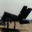

In [57]:
with open("./sample1.png", "rb") as image:
  f = image.read()
  b = bytearray(f)
  print(type(b))
  
import io
img_b = io.BytesIO(b)

from PIL import Image
Image.open(img_b)

In [58]:
len(b)

2151